In [1]:
import os
import psycopg
import pandas as pd

TABLE_NAME = 'flats_clean_table'

os.environ["DB_DESTINATION_HOST"] = os.getenv("DB_DESTINATION_HOST")
os.environ["DB_DESTINATION_PORT"] = os.getenv("DB_DESTINATION_PORT")
os.environ["DB_DESTINATION_NAME"] = os.getenv("DB_DESTINATION_NAME")
os.environ["DB_DESTINATION_USER"] = os.getenv("DB_DESTINATION_USER")
os.environ["DB_DESTINATION_PASSWORD"] = os.getenv("DB_DESTINATION_PASSWORD")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ["DB_DESTINATION_HOST"], 
    "port": os.environ["DB_DESTINATION_PORT"],
    "dbname": os.environ["DB_DESTINATION_NAME"],
    "user": os.environ["DB_DESTINATION_USER"],
    "password": os.environ["DB_DESTINATION_PASSWORD"],
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, df['price'], test_size=0.2, random_state=42)
num_columns = ['floor', 'kitchen_area', 'living_area', 'rooms',
               'total_area', 'build_year', 'building_type_int', 
               'latitude', 'longitude', 'ceiling_height', 'flats_count',
               'floors_total']
cat_columns = ['is_apartment','has_elevator']

Previous model fit:

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import json

preprocessor = ColumnTransformer(
    [
        ('num_cols_norm', StandardScaler(), num_columns),
        ('cat_cols_encode', OneHotEncoder(drop='if_binary'), cat_columns)
    ]
)
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)
pipeline.fit(X_train, y_train)
prediction = pipeline.predict(X_test)
metric = {}
mae = mean_absolute_error(y_test, prediction)
metric['mae'] = mae
with open('metrics.json', 'w') as f:
    json.dump(metric, f)

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    SplineTransformer, 
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)

num_columns = ['floor', 'kitchen_area', 'living_area', 'rooms',
               'total_area', 'build_year', 'building_type_int', 
               'latitude', 'longitude', 'ceiling_height', 'flats_count',
               'floors_total']
cat_columns = ['is_apartment','has_elevator']

encoder_oh = OneHotEncoder(categories='auto', handle_unknown='ignore', sparse_output=False, drop='first')
encoder_spl = SplineTransformer(n_knots=3, degree=4)
encoder_q = QuantileTransformer(n_quantiles=100)
encoder_rb = RobustScaler()
encoder_pol = PolynomialFeatures(degree=3)
encoder_kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform', subsample=None)

transformer = ColumnTransformer(
  transformers=[
      ('encoder', encoder_oh, cat_columns),
      ('spl', encoder_spl, num_columns), 
      ('q', encoder_q, num_columns), 
      ('rb', encoder_rb, num_columns), 
      ('pol', encoder_pol, num_columns), 
      ('kbd', encoder_kbd, num_columns)
  ], n_jobs=-1
)


In [5]:
pipeline_fe = Pipeline(
    [
        ('preprocessor', transformer),
        ('model', model)
    ]
)
pipeline_fe.fit(X_train, y_train)
prediction_fe = pipeline_fe.predict(X_test)
metric_fe = {}
mae = mean_absolute_error(y_test, prediction_fe)
metric_fe['mae'] = mae

In [6]:
from autofeat import AutoFeatRegressor
autofeat = AutoFeatRegressor(feateng_steps=2, max_gb=16, transformations=['1+', 'sqrt', 'abs'])

In [7]:
autofeat_tr = ColumnTransformer(
    transformers=[
        ("autofeat", autofeat, num_columns)
    ]
)

In [8]:
X_train_features = transformer.fit_transform(X_train, y_train)
new_X_train = autofeat_tr.fit_transform(X_train, y_train)
model.fit(new_X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
X_test_features = transformer.transform(X_test)
new_X_test = autofeat_tr.transform(X_test)
prediction_fe_af = model.predict(new_X_test)

In [10]:

metric_fe_af = {}
mae = mean_absolute_error(y_test, prediction_fe_af)
metric_fe_af['mae'] = mae

In [11]:
metric_fe

{'mae': 2737354.883970575}

In [12]:
metric_fe_af

{'mae': 2677902.883466634}

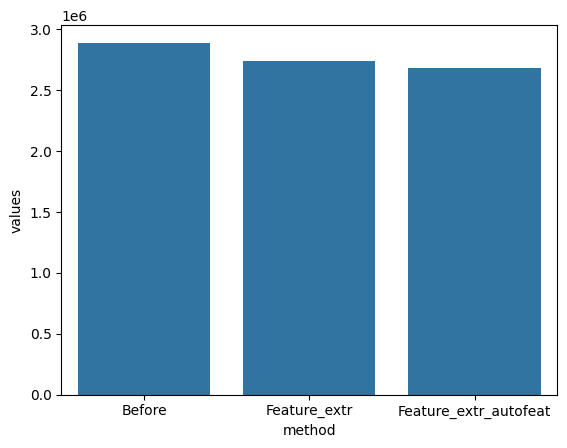

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

ASSETS_DIR = '../assets'
os.makedirs(ASSETS_DIR, exist_ok=True)

data = pd.DataFrame({
    'method': ['Before', 'Feature_extr', 'Feature_extr_autofeat'],
    'values': [metric['mae'], metric_fe['mae'], metric_fe_af['mae']]
})
sns.barplot(x='method', y='values',data=data)
plt.savefig(os.path.join(ASSETS_DIR,'metrics_improvement_extracting'))

In [14]:
import mlflow
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
mlflow.set_tracking_uri(tracking_uri)
mlflow.set_registry_uri(tracking_uri)

In [15]:
EXPERIMENT_NAME = "yandex_realty_aleksandra"
REGISTRY_MODEL_NAME = "better_model_aleksandra"
RUN_NAME = 'save_better_model'

In [16]:

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(new_X_test, prediction_fe_af)
input_example = new_X_test[:10]
metadata = {'model_type': 'monthly'}

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not (experiment_id):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment_id.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # ваш код здесь
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        pip_requirements=pip_requirements,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        artifact_path='models',
        await_registration_for=60
    )
    mlflow.log_metrics(metrics=metric_fe_af)
    mlflow.log_artifact(ASSETS_DIR)
    


2025-01-16 08:55:18,860 INFO: Found credentials in environment variables.
Registered model 'better_model_aleksandra' already exists. Creating a new version of this model...
2025/01/16 08:55:20 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: better_model_aleksandra, version 5
Created version '5' of model 'better_model_aleksandra'.


In [63]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

estimator = model
sfs = SFS(estimator, k_features=15, forward=True, floating=False, scoring='neg_mean_absolute_error', cv=4, n_jobs=-1)
sbs = SFS(estimator, k_features=15, forward=False, floating=False, scoring='neg_mean_absolute_error', cv=4, n_jobs=-1)

sfs = sfs.fit(new_X_train, y_train)
sbs = sbs.fit(new_X_train, y_train)

top_sfs = sfs.k_feature_names_
top_sbs = sbs.k_feature_names_

In [64]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 


sfs_df.to_csv(f"{ASSETS_DIR}/sfs.csv")
sbs_df.to_csv(f"{ASSETS_DIR}/sbs.csv") 

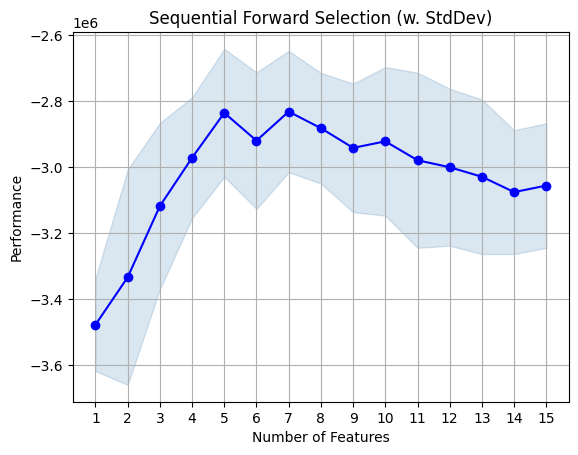

<Figure size 640x480 with 0 Axes>

In [65]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{ASSETS_DIR}/sfs.png") 

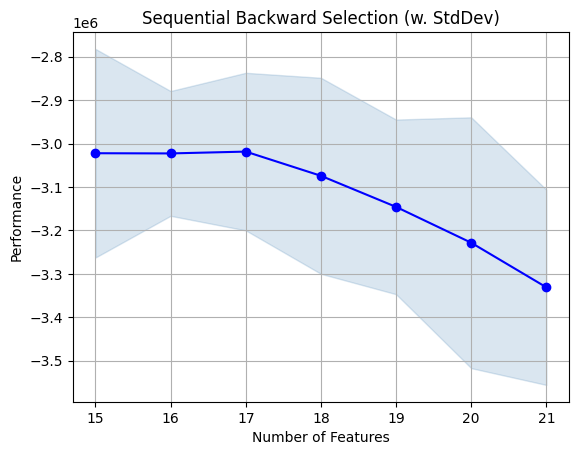

<Figure size 640x480 with 0 Axes>

In [66]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{ASSETS_DIR}/sbs.png") 

In [75]:
sfs_features = [int(el) for el in list(top_sfs)]
sbs_features = [int(el) for el in list(top_sbs)]
interc_features = list(set(sfs_features) & set(sbs_features))
union_features = list(set(sfs_features) | set(sbs_features))

In [86]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, sfs_features], y_train)
prediction_sfs = model.predict(new_X_test[:, sfs_features])
metric_sfs = {}
mae = mean_absolute_error(y_test, prediction_sfs)
metric_sfs['mae'] = mae

In [88]:
metric_sfs

{'mae': 2655904.091251145}

In [89]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, sbs_features], y_train)
prediction_sbs = model.predict(new_X_test[:, sbs_features])
metric_sbs = {}
mae = mean_absolute_error(y_test, prediction_sbs)
metric_sbs['mae'] = mae

In [90]:
metric_sbs

{'mae': 2633170.637247252}

In [91]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, union_features], y_train)
prediction_union = model.predict(new_X_test[:, union_features])
metric_union = {}
mae = mean_absolute_error(y_test, prediction_union)
metric_union['mae'] = mae

In [92]:
metric_union

{'mae': 2596571.5302121895}

In [93]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, interc_features], y_train)
prediction_interc = model.predict(new_X_test[:, interc_features])
metric_interc = {}
mae = mean_absolute_error(y_test, prediction_interc)
metric_interc['mae'] = mae

In [94]:
metric_interc

{'mae': 2746676.392526706}

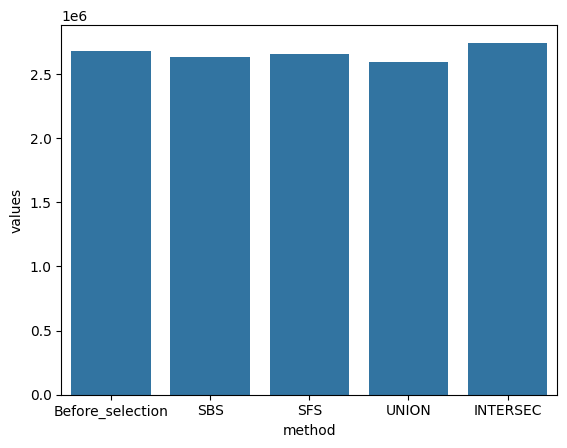

In [119]:
data = pd.DataFrame({
    'method': ['Before_selection','SBS', 'SFS', 'UNION', 'INTERSEC'],
    'values': [metric_fe_af['mae'],metric_sbs['mae'], metric_sfs['mae'], metric_union['mae'], metric_interc['mae']]
})
sns.barplot(x='method', y='values',data=data)
plt.savefig(os.path.join(ASSETS_DIR,'metrics_improvement_selection'))

UNION is the best according to mae

In [121]:
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(new_X_train[:, union_features], y_train)
prediction_union = model.predict(new_X_test[:, union_features])
metric_union = {}
mae = mean_absolute_error(y_test, prediction_union)
metric_union['mae'] = mae

In [120]:
EXPERIMENT_NAME = "yandex_realty_aleksandra"
REGISTRY_MODEL_NAME = "selection_model_aleksandra"
RUN_NAME = 'save_selection_model'

In [122]:

pip_requirements = "../requirements.txt"
signature = mlflow.models.infer_signature(new_X_test[:, union_features], prediction_union)
input_example = new_X_test[:, union_features]
metadata = {'model_type': 'monthly'}

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not (experiment_id):
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment_id.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    # ваш код здесь
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        pip_requirements=pip_requirements,
        metadata=metadata,
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        artifact_path='models',
        await_registration_for=60
    )
    mlflow.log_metrics(metrics=metric_union)
    mlflow.log_artifact(ASSETS_DIR)
    


Successfully registered model 'selection_model_aleksandra'.
2025/01/16 08:47:53 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: selection_model_aleksandra, version 1
Created version '1' of model 'selection_model_aleksandra'.
